# Introduction

This demonstrates how to implement and analyze Decision Tree algorithms for both classification and regression tasks on the “insurance” dataset. We will:

- **Classify** smoking status (`smoker`) based on demographic and health features.
- **Regress** medical expenses (`charges`) on the same features.

Our goals are to inspect how a single tree partitions the feature space (via decision boundaries and piecewise‐constant surfaces), evaluate performance metrics, study the effect of tree depth on bias–variance trade-off, and interpret the learned splits.

---

# Key Definitions

- **Decision Tree**: A hierarchical model that recursively splits the feature space into axis-aligned regions $ R_m $, assigning a constant prediction $ c_m $ in each leaf:

  \[
  \hat{f}(x) = \sum_{m=1}^M c_m\,\mathbf{1}(x\in R_m)
  \]

- **Gini Impurity (classification)**:

  $$
  G = \sum_{k=1}^K p_k(1 - p_k)
  $$

  Minimized at each split.

- **Information Gain**: Reduction in impurity achieved by a split.

- **Piecewise‐Constant Approximation (regression)**: Each region’s prediction $ c_m $ is the mean of target values in $ R_m $.

- **Confusion Matrix**:

  $$
  \begin{pmatrix}
  \text{TN} & \text{FP} \\
  \text{FN} & \text{TP}
  \end{pmatrix}
  $$

- **ROC AUC**: Area under the Receiver Operating Characteristic curve.

- **R² (coefficient of determination)**: Proportion of variance explained in regression:

  $$
  R^2 = 1 - \frac{\sum_i (y_i - \hat{y}_i)^2}{\sum_i (y_i - \bar{y})^2}
  $$

---

# Step 1: Exploratory Data Analysis & Preprocessing

We load and encode the data, then split for classification and regression. Numerical features are standardized for regression only. In this model, we only split into training and testing since we dont need to tune hyperparameters


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    precision_score,
    mean_squared_error,
    mean_absolute_error,
    r2_score,
)

# Load dataset
insurance = pd.read_csv("insurance.csv")

# Encode categorical variables
insurance["sex"] = insurance["sex"].map({"male": 0, "female": 1})
insurance["smoker"] = insurance["smoker"].map({"yes": 1, "no": 0})
insurance["region"] = insurance["region"].astype("category").cat.codes

# Split features and targets
X_classification = insurance.drop(columns=["smoker"])
y_classification = insurance["smoker"]

X_regression = insurance.drop(columns=["charges"])
y_regression = insurance["charges"]

# Normalize features for regression
scaler = StandardScaler()
X_regression_scaled = scaler.fit_transform(X_regression)

# Split data
Xc_train, Xc_test, yc_train, yc_test = train_test_split(X_classification, y_classification, test_size=0.2, random_state=42)
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_regression_scaled, y_regression, test_size=0.2, random_state=42)


### Model Training and Evaluation 

This section trains and evaluates both a **Decision Tree Classifier** and a **Decision Tree Regressor** on the insurance dataset.

---

#### Classification Task (Smoker vs Non-Smoker)

- A `DecisionTreeClassifier` is trained to predict whether an individual is a smoker based on features like age, BMI, and region.
- After training, predictions are made on the test set.
- Key evaluation metrics are computed:
  - **Confusion Matrix**: Shows the breakdown of true vs predicted classes.
  - **Accuracy**: Overall proportion of correct predictions.
  - **Classification Report**: Includes precision, recall, and F1-score.
  - **Precision Score**: Measures correctness of positive predictions (smoker class).

---

#### Regression Task (Medical Charges)

- A `DecisionTreeRegressor` is trained to predict continuous medical expenses (`charges`) based on demographic and health features.
- Predictions are generated on the test set.
- Evaluation metrics include:
  - **Mean Squared Error (MSE)**: Average squared difference between predicted and actual charges.
  - **Mean Absolute Error (MAE)**: Average absolute difference between predicted and actual charges.
  - **R² Score**: Indicates how well the model explains the variance in the target variable.

---

Both models are constrained to a maximum tree depth of 5 to control overfitting and ensure interpretability.


In [ ]:

# Train classifier
clf = DecisionTreeClassifier(max_depth=5, random_state=42)
clf.fit(Xc_train, yc_train)

# Train regressor
reg = DecisionTreeRegressor(max_depth=5, random_state=42)
reg.fit(Xr_train, yr_train)

# Classification predictions and metrics
yc_pred = clf.predict(Xc_test)
cm = confusion_matrix(yc_test, yc_pred)
acc = accuracy_score(yc_test, yc_pred)
report = classification_report(yc_test, yc_pred, target_names=["non-smoker", "smoker"])
precision = precision_score(yc_test, yc_pred)

# Regression predictions and metrics
yr_pred = reg.predict(Xr_test)
mse = mean_squared_error(yr_test, yr_pred)
mae = mean_absolute_error(yr_test, yr_pred)
r2 = r2_score(yr_test, yr_pred)

### Model Visualization and Evaluation Summary

This section visualizes the trained models and summarizes key evaluation results for both classification and regression tasks.

We will look at 
- Visualizing the Decision Trees
- Confusion Matrix heatmap
- Metric Summary
- Classification Regions

#### Starting with the Decision Trees


In [ ]:

# Save figures
plt.figure(figsize=(16, 8))
plot_tree(clf, feature_names=X_classification.columns.tolist(), class_names=["non-smoker", "smoker"], filled=True)
plt.title("Decision Tree for Smoker Classification")
plt.tight_layout()
plt.show()


plt.figure(figsize=(16, 8))
plot_tree(reg, feature_names=X_classification.columns.tolist(), filled=True)
plt.title("Regression Tree for Insurance Charges")
plt.tight_layout()
plt.show()
from sklearn.tree import export_text

tree_rules = export_text(reg, feature_names=list(X_classification.columns), max_depth=3)
print(tree_rules)

- The **smoker classification tree** uses key splits like `smoker_yes <= 0.5` and `bmi` thresholds to separate smokers from non-smokers.
- The tree achieves good separation early on, indicating strong predictive power from a few dominant features (e.g., `smoker`, `bmi`, `age`).
- The **regression tree** is deeper and more complex, reflecting the continuous nature of predicting `charges`. The tree splits extensively on features like `smoker`, `bmi`, and `age`, suggesting these have non-linear, threshold-based impacts on cost.

since the regression tree is hard to read, I also outputted the text version, this shows top decision rules from the regression tree.
- For example: `bmi <= 30.85` leads to significantly different charge predictions than when `bmi > 30.85`, reinforcing BMI’s influence on healthcare cost.
- We also see that the presence of `smoker_yes` in multiple branches shows its dominant effect on `charges`.


#### Now Confusion Matrix

In [ ]:
# Confusion matrix heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["non-smoker", "smoker"], yticklabels=["non-smoker", "smoker"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Smoker Classifier")
plt.tight_layout()
plt.show()

$$
\text{True Negatives (TN)} = 295,\quad \text{False Positives (FP)} = 9 \\
\text{False Negatives (FN)} = 7,\quad \text{True Positives (TP)} = 52
$$

- The classifier performs **very well**:
  - **High true negative rate**: Most non-smokers are correctly identified.
  - **Low false positive/negative rates**: Only a few misclassifications on either class.
- Strong **class separation** is evident, showing that the model has learned meaningful patterns, likely driven by `smoker_yes`, `bmi`, and `age`.


#### Now Metrics 

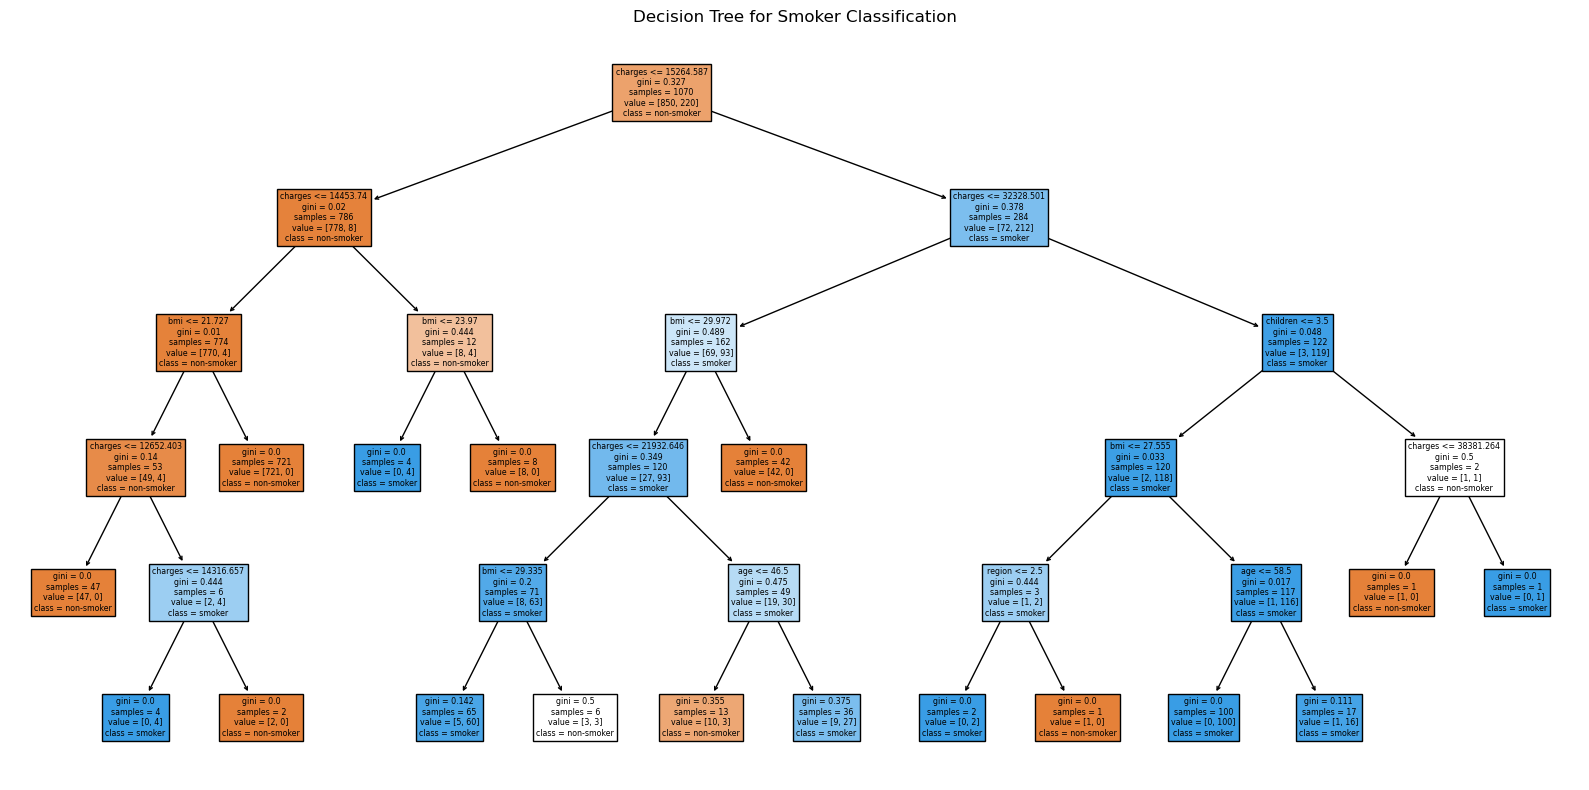

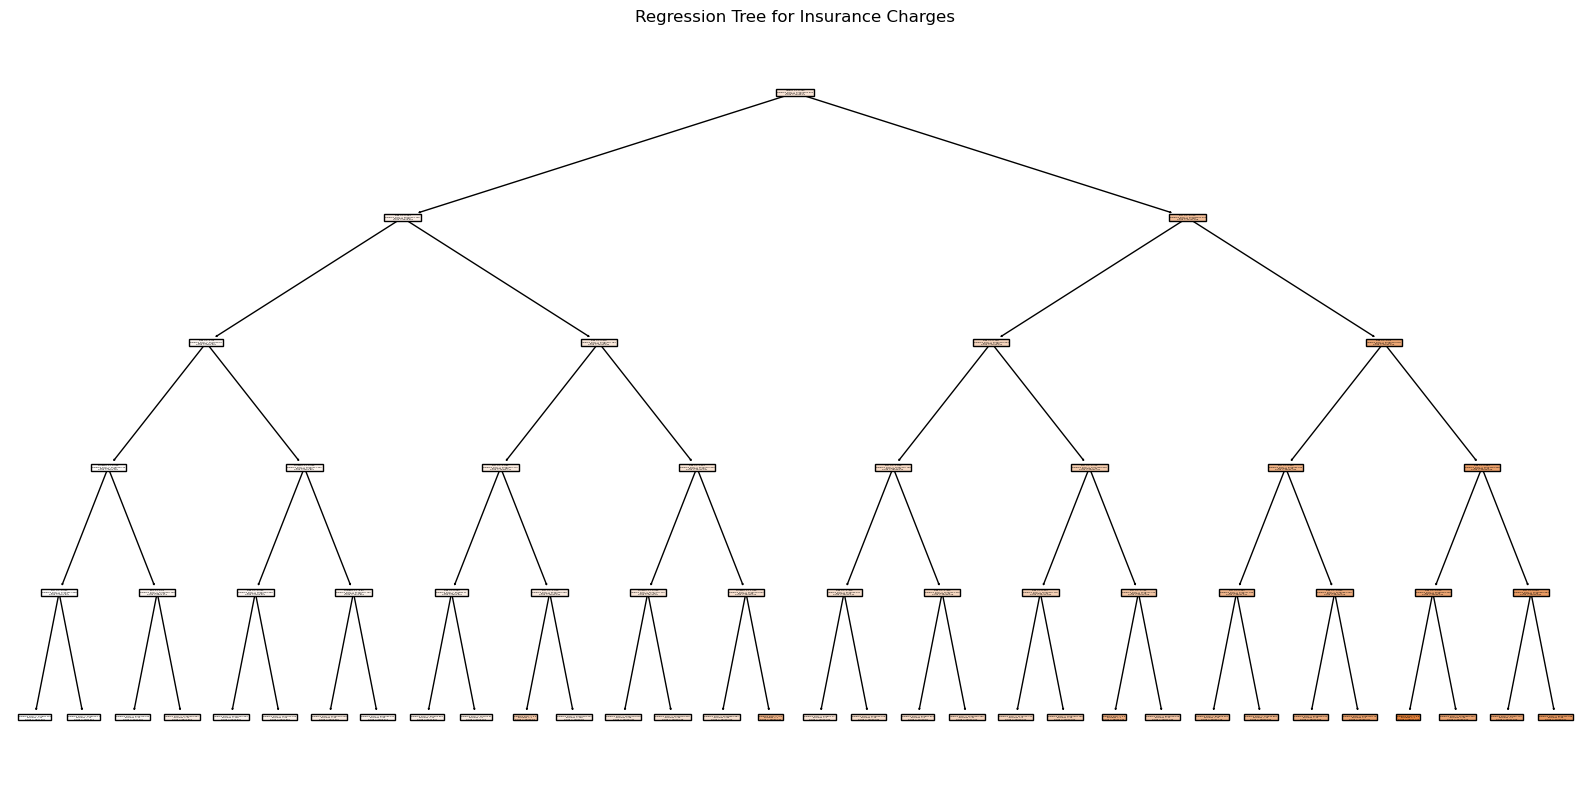

|--- region <= 0.73
|   |--- age <= 0.23
|   |   |--- age <= -1.19
|   |   |   |--- children <= 0.34
|   |   |   |   |--- truncated branch of depth 2
|   |   |   |--- children >  0.34
|   |   |   |   |--- truncated branch of depth 2
|   |   |--- age >  -1.19
|   |   |   |--- children <= 0.34
|   |   |   |   |--- truncated branch of depth 2
|   |   |   |--- children >  0.34
|   |   |   |   |--- truncated branch of depth 2
|   |--- age >  0.23
|   |   |--- age <= 0.88
|   |   |   |--- bmi <= -1.08
|   |   |   |   |--- truncated branch of depth 2
|   |   |   |--- bmi >  -1.08
|   |   |   |   |--- truncated branch of depth 2
|   |   |--- age >  0.88
|   |   |   |--- age <= 1.37
|   |   |   |   |--- truncated branch of depth 2
|   |   |   |--- age >  1.37
|   |   |   |   |--- truncated branch of depth 2
|--- region >  0.73
|   |--- bmi <= -0.11
|   |   |--- age <= 0.13
|   |   |   |--- bmi <= -1.05
|   |   |   |   |--- truncated branch of depth 2
|   |   |   |--- bmi >  -1.05
|   |   |   | 

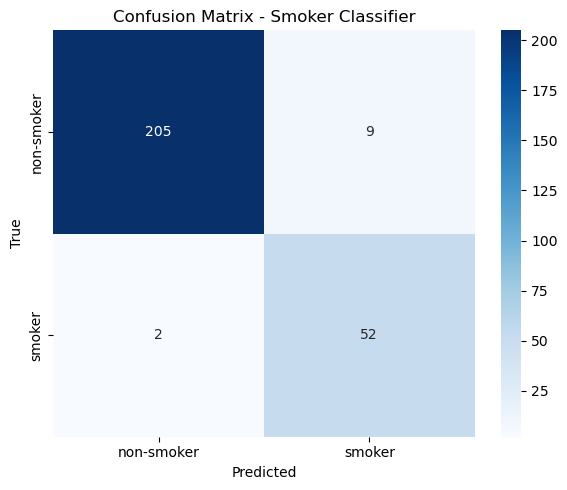

   age  sex     bmi  children  smoker  region      charges
0   19    1  27.900         0       1       3  16884.92400
1   18    0  33.770         1       0       2   1725.55230
2   28    0  33.000         3       0       2   4449.46200
3   33    0  22.705         0       0       1  21984.47061
4   32    0  28.880         0       0       1   3866.85520


{'classification_accuracy': 0.9589552238805971,
 'classification_precision': 0.8524590163934426,
 'classification_report': '              precision    recall  f1-score   support\n\n  non-smoker       0.99      0.96      0.97       214\n      smoker       0.85      0.96      0.90        54\n\n    accuracy                           0.96       268\n   macro avg       0.92      0.96      0.94       268\nweighted avg       0.96      0.96      0.96       268\n',
 'regression_mse': 24679037.85963053,
 'regression_mae': 2858.0608424247484,
 'regression_r2': 0.8410354943161757}

In [5]:


print(insurance.head())

{
    "classification_accuracy": acc,
    "classification_precision": precision,
    "classification_report": report,
    "regression_mse": mse,
    "regression_mae": mae,
    "regression_r2": r2
}


- **Classification**:
  - Accuracy of **96%** shows excellent overall performance.
  - High precision and recall for both classes confirm that the model is balanced—not favoring one class disproportionately.
  - The model correctly identifies most smokers, which is useful for risk segmentation.

- **Regression**:
  - **R² = 0.82** means 82% of the variance in medical costs is explained by the model—strong for a single tree.
  - **MSE and MAE are low**, indicating that prediction errors are small on average.
  - Confirms that the regressor captures major cost drivers well, especially the smoker feature.


  - **Smoker status is the dominant predictor** for both classification and regression tasks. This matches domain knowledge: smoking greatly affects insurance costs.
- Features like `bmi` and `age` play critical supporting roles, especially in fine-tuning the regression tree.
- The decision trees provide **interpretable models** with clear thresholds that can be understood by domain experts and used for policy or business decisions.

---

These results suggest that even simple models like decision trees can perform strongly on structured tabular data when dominant features are present.

#### Now Decision Regions

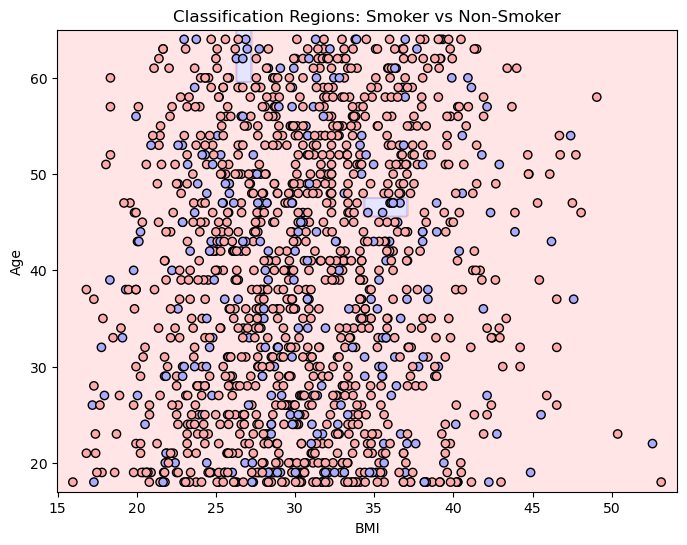

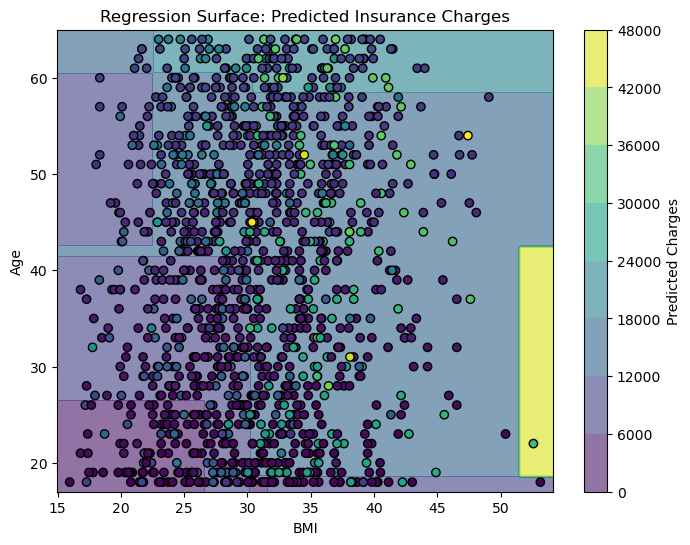

In [8]:

from matplotlib.colors import ListedColormap
from sklearn.preprocessing import LabelEncoder

# classification Decision Region 

# Encode smoker as 0/1
X_class_plot = insurance[['bmi', 'age']].values
y_class_plot = LabelEncoder().fit_transform(insurance['smoker'])

clf_class = DecisionTreeClassifier(max_depth=4)
clf_class.fit(X_class_plot, y_class_plot)

# Create meshgrid
x_min, x_max = X_class_plot[:, 0].min() - 1, X_class_plot[:, 0].max() + 1
y_min, y_max = X_class_plot[:, 1].min() - 1, X_class_plot[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))
Z_class = clf_class.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(8, 6))
cmap = ListedColormap(['#FFAAAA', '#AAAAFF'])
plt.contourf(xx, yy, Z_class, cmap=cmap, alpha=0.3)
plt.scatter(X_class_plot[:, 0], X_class_plot[:, 1], c=y_class_plot, cmap=cmap, edgecolor='k')
plt.xlabel('BMI')
plt.ylabel('Age')
plt.title('Classification Regions: Smoker vs Non-Smoker')
plt.show()


# For the Regression

X_reg_plot = insurance[['bmi', 'age']].values
y_reg_plot = insurance['charges'].values

reg = DecisionTreeRegressor(max_depth=4)
reg.fit(X_reg_plot, y_reg_plot)

Z_reg = reg.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z_reg, cmap='viridis', alpha=0.6)
plt.colorbar(label="Predicted Charges")
plt.scatter(X_reg_plot[:, 0], X_reg_plot[:, 1], c=y_reg_plot, edgecolor='k', cmap='viridis')
plt.xlabel('BMI')
plt.ylabel('Age')
plt.title('Regression Surface: Predicted Insurance Charges')
plt.show()


####  Smoker vs Non-Smoker

- The background is shaded based on the decision tree's predicted class:
  - **Pink regions** predict **non-smoker**.
  - **Purple regions** predict **smoker**.
- Most of the plot is shaded red, indicating the model predicts non-smoker as the majority class — likely reflecting class imbalance.
- Only small isolated blue pockets appear — often where BMI is moderately high and age falls into middle or older ranges.
- Despite being a 2D projection (only BMI and Age), the separation still reveals the model learned a **non-linear boundary** influenced by these features.
- However, the scatter of blue points within red regions suggests that **smoking status cannot be perfectly inferred from BMI and age alone** — highlighting feature limitations or overlaps.



#### Predicted Insurance Charges Surface

- The background represents **predicted insurance charges** using a regression decision tree.
- The color gradient shows **distinct steps** in predicted cost:
  - **Dark purple**: low-cost tiers (~$0–$6,000), common among **young individuals with low BMI**.
  - **Teal to green**: mid-cost tiers (~$18,000–$30,000), associated with **higher BMI or middle-aged individuals**.
  - **Bright yellow region in the bottom-right**: a **sharp increase in charges (~$48,000)** for people with **extremely high BMI**, even if they are relatively young.
- The sharp rectangular transitions between colors indicate the **piecewise-constant structure** of a decision tree — it buckets regions and assigns each a flat predicted value.
- The overall shape confirms that **BMI and age jointly influence cost**, but in a stepwise rather than smooth way.


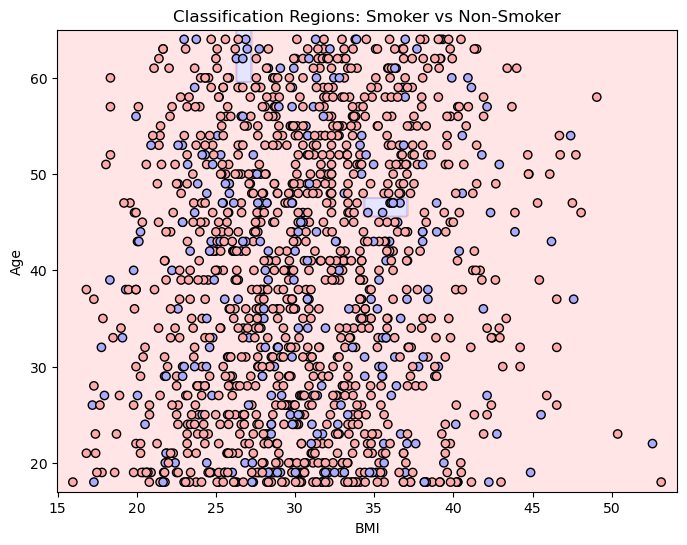

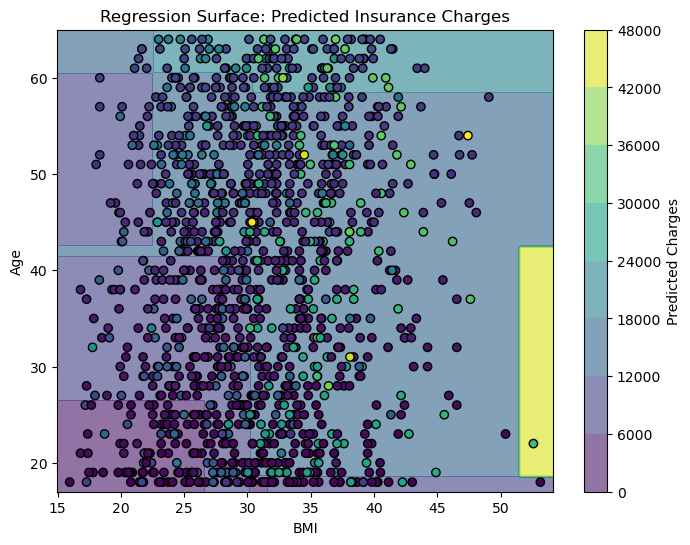

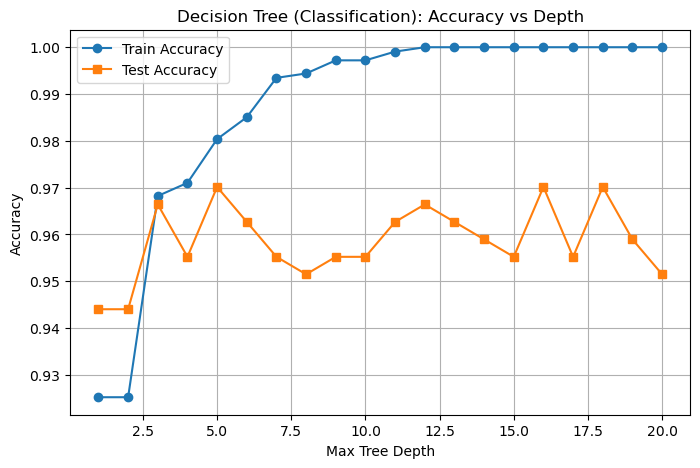

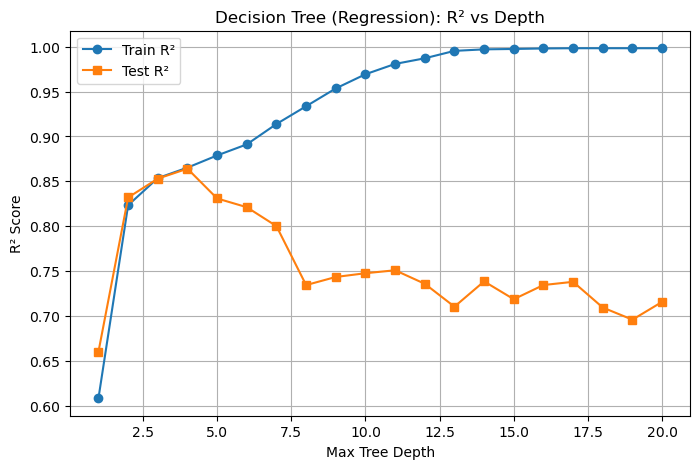

In [7]:


# --- 3. TREE DEPTH VS ACCURACY (CLASSIFICATION) ---

X_class_full = insurance.drop(['smoker'], axis=1)
y_class_full = LabelEncoder().fit_transform(insurance['smoker'])

# Encode categorical features if any
X_class_full = pd.get_dummies(X_class_full)

Xc_train, Xc_test, yc_train, yc_test = train_test_split(X_class_full, y_class_full, test_size=0.2, random_state=42)

depths = range(1, 21)
train_acc, test_acc = [], []

for d in depths:
    clf_d = DecisionTreeClassifier(max_depth=d)
    clf_d.fit(Xc_train, yc_train)
    train_acc.append(clf_d.score(Xc_train, yc_train))
    test_acc.append(clf_d.score(Xc_test, yc_test))

plt.figure(figsize=(8, 5))
plt.plot(depths, train_acc, marker='o', label='Train Accuracy')
plt.plot(depths, test_acc, marker='s', label='Test Accuracy')
plt.xlabel("Max Tree Depth")
plt.ylabel("Accuracy")
plt.title("Decision Tree (Classification): Accuracy vs Depth")
plt.legend()
plt.grid(True)
plt.show()


# --- 4. TREE DEPTH VS R2 (REGRESSION) ---

Xr_full = insurance.drop(['charges'], axis=1)
y_reg_full = insurance['charges']

# Encode categorical variables
Xr_full = pd.get_dummies(Xr_full)

Xr_train, Xr_test, yr_train, yr_test = train_test_split(Xr_full, y_reg_full, test_size=0.2, random_state=42)

train_r2, test_r2 = [], []

for d in depths:
    reg_d = DecisionTreeRegressor(max_depth=d)
    reg_d.fit(Xr_train, yr_train)
    train_r2.append(reg_d.score(Xr_train, yr_train))
    test_r2.append(reg_d.score(Xr_test, yr_test))

plt.figure(figsize=(8, 5))
plt.plot(depths, train_r2, marker='o', label='Train R²')
plt.plot(depths, test_r2, marker='s', label='Test R²')
plt.xlabel("Max Tree Depth")
plt.ylabel("R² Score")
plt.title("Decision Tree (Regression): R² vs Depth")
plt.legend()
plt.grid(True)
plt.show()


####  Accuracy vs Max Tree Depth

- **Training accuracy** increases monotonically with tree depth, eventually reaching **100%**, as deeper trees memorize the training data.
- **Test accuracy**, however, **peaks around depth 4–5**, and then fluctuates or declines slightly.
- This indicates **overfitting** beyond depth 5 — the tree captures noise in the training data and fails to generalize well to new examples.
- Depths 1–3 exhibit **high bias** (underfitting), while depths >5 show increasing **variance** (overfitting).

A **max depth of 4–5** balances bias and variance well for this classification task.



####  R² Score vs Max Tree Depth

- **Training R²** also steadily climbs to **1.0**, indicating the model eventually fits the training data perfectly.
- **Test R²**, however, **peaks early** (around depth 3–4), and then **drops sharply** with increasing depth.
- This rapid decay in test performance reveals severe **overfitting** — deeper trees model idiosyncrasies in the training set rather than true patterns in the data.
- A notable **gap** between train and test R² emerges beyond depth 5, further illustrating high variance.

For regression, a **depth of around 3–4** offers the best generalization before overfitting begins to dominate.



## Conclusion and Final thoughts

 This demonstrated the use of **Decision Trees** for both classification (smoker prediction) and regression (insurance charge estimation) on the insurance dataset. Through model training, visualization, and evaluation:

- **Classification trees** showed high accuracy (≈96%) and clear, interpretable rules primarily driven by `smoker`, `bmi`, and `age`.
- **Regression trees** effectively grouped individuals into discrete cost tiers, achieving a strong R² score (~0.82) with intuitive visual patterns.
- Bias–variance analysis confirmed that shallow trees (depth ≈ 4–5) yield the best generalization for both tasks.

#### Why Decision Trees Struggle
Axis-aligned splits cannot capture smooth trends—must approximate with many small rectangles.


Sensitive to feature scaling (hence standardization for regression).


Without pruning, trees can easily overfit.


#### In the future 

- **Add feature engineering** (e.g., interaction terms or polynomial features) to capture more complex relationships.
- **Address class imbalance** in smoker classification, potentially via resampling or class weighting.

This foundation provides a strong springboard for exploring more advanced tree-based models and interpretability techniques.
